In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
# import string
import nltk
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
# import plotly.express as ex
# import plotly.graph_objs as go
# import plotly.offline as pyo
from plotly.subplots import make_subplots
# pyo.init_notebook_mode()
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# from nltk.util import ngrams
# from nltk import word_tokenize
# from nltk.stem import PorterStemmer
# from nltk.stem import WordNetLemmatizer
# import random

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**PREPARING THE INPUT DATASET**

In [3]:
df_prof = pd.read_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df_professionals.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,6,7,8,10,20,26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df1_lemm = pd.read_csv('/content/drive/MyDrive/Colab_TwitterIndicators/df1_lemmatized.csv')

In [5]:
df = pd.merge(df_prof,df1_lemm,how='inner',on=['id'])

In [6]:
df = df.drop(['Unnamed: 0_x','retweetPostedTime', 'retweetId',
       'retweetBody', 'retweetSource', 'retweetUserId',
       'retweetUserDisplayName', 'retweetUserLocation', 'retweetUserSummary',
       'retweetUserStatusesCount', 'retweetUserLang',
       'retweetUserPreferredName', 'retweetUserVerified',
       'retweetUserFollowersCount', 'retweetUserFriendsCount',
       'retweetUserFavouritesCount', 'retweetUserPostedTime', 'postedtime_x',
       'Unnamed: 0_y','retweetbody'],axis=1)

In [8]:
df['tweet_date'] = df['tweet_dt'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
df['dt'] = pd.to_datetime(df['tweet_date'])

**FILTER THE DATASET BASED ON DATE RANGE: [2020-2021]**

In [42]:
#FILTER DATASET BASED ON A YEARLY RANGE

# df_filtered = df[(df['dt'] >= '2020-01-01') & (df['dt'] <= '2021-12-31')]
# df = df_filtered.drop(['covid_range', 'tweet_date','postedtime_y','retweetcount', 'userPostedTime'],axis = 1)

# SENTIMENT ANALYSIS

In [12]:
def sentiment_analysis(df):

  sid = SIA()
  df['sentiments'] = df['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
  df['Positive Sentiment'] = df['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
  df['Neutral Sentiment']= df['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
  df['Negative Sentiment']= df['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

  df.drop(columns=['sentiments'],inplace=True)
  
  return df

In [13]:
df_sentiment = sentiment_analysis(df)

**PLOT DISTRIBUTION SENTIMENTS**

In [14]:
def plot_sentiments(df, title):

    plt.figure(figsize=(20,10))
    plt.title('Distribution Of Sentiments Across Our Tweets by '+ title,fontsize=19,fontweight='bold')
    sns.kdeplot(df['Negative Sentiment'],bw_method=0.1,label = 'Negative')
    sns.kdeplot(df['Positive Sentiment'],bw_method=0.1,label = 'Positive')
    sns.kdeplot(df['Neutral Sentiment'],bw_method=0.1,label = 'Neutral')
    plt.xlabel('Sentiment scores')
    plt.legend()
    plt.show()

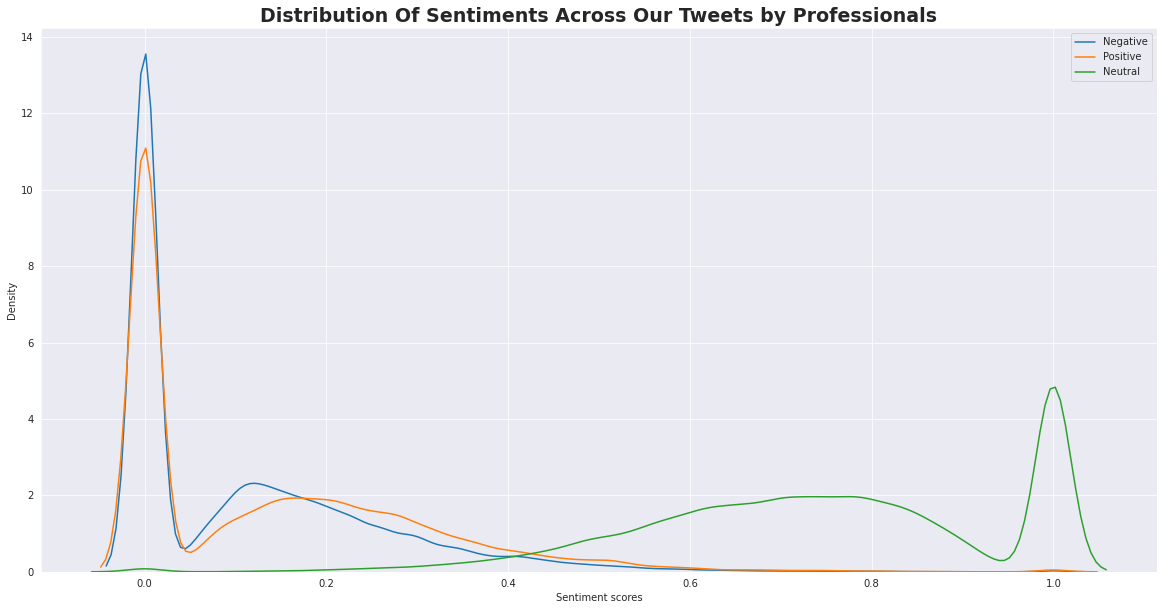

In [15]:
plot_sentiments(df_sentiment, 'Professionals')

L'idea è di plottare la distribution delle sentiments per topic diversi (inflazione,bitcoin, petrolio,energia, oro etc)  in uno specifico arco temporale (es. 2020-2021 covid) e confrontare tra di loro i risultati. 
L'indicatore sarà quindi il sentiment per quel topic (vedendo ad esempio quanto i diversi topic hanno un andamento simile a quello dell'inflazione). 

Fare lo stesso procedimento per df_men e df_professional confrontando i risultati e vedere quale dei due ha un influenza maggiore sul sentiment dell'inflazione

In [16]:
#SALVATAGGIO DEI VALORI MASSIMI TRA I 3 SENTIMENT E LA RISPETTIVA CLASSE DI APPARTENZA
def create_df_sent(df, df_original):
  df_sentiment = df[['Negative Sentiment','Positive Sentiment','Neutral Sentiment']]
  df_sentiment['Max_SentimentCol'] = df_sentiment.idxmax(axis=1)
  df_sentiment['Max_SentimentValue'] = df_sentiment[['Negative Sentiment','Positive Sentiment','Neutral Sentiment']].max(axis=1)
  df_sentiment = df_sentiment.drop(['Negative Sentiment','Positive Sentiment','Neutral Sentiment'],axis=1)
  # UNIONE DEL DF APPENA CREATO E IL DF ORIGINARIO
  df_new = df_sentiment.join(df_original)
  return df_new

In [17]:
df_new = create_df_sent(df_sentiment,df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [18]:
#TRASFORMANDO IN DATE LE STRINGHE PER POTER RAGGRUPARE LA MEDIA DEI VALORI MASSIMI DI SENTIMENT SCORE PER CATEGORIA (POS,NEG,NEUTRAL) E MESE
def plot_sent_distribution(df_new,title):

  list_YM = [i.split(" ")[0][:-3] for i in  list(df_new['tweet_dt'])]
  list_Year = [i.split(" ")[0][0:4] for i in  list(df_new['tweet_dt'])]
  list_Month = [i.split(" ")[0][5:7] for i in  list(df_new['tweet_dt'])]

  df_mean = pd.DataFrame()

  df_new['YM'] = list_YM
  df_new['Year'] = list_Year
  df_new['Month'] = list_Month

  #create a monthly dataframe
  df_mean = df_new.groupby(['Max_SentimentCol', 'YM', 'Year', 'Month']).mean()
  df_mean = df_mean[['Max_SentimentValue']].reset_index()

  sns.set(rc={'figure.figsize':(30,10)})
  ax = sns.lineplot(data=df_mean, x = 'YM', y='Max_SentimentValue',hue='Max_SentimentCol',palette='viridis',legend='full',lw=3)
  plt.legend(bbox_to_anchor=(1, 1))
  plt.title('Distribution of the sentiment score over time by ' + title)
  plt.ylabel('Mean Sentiment Score')
  plt.xlabel('Year-Month')
  plt.show()
  return df_mean

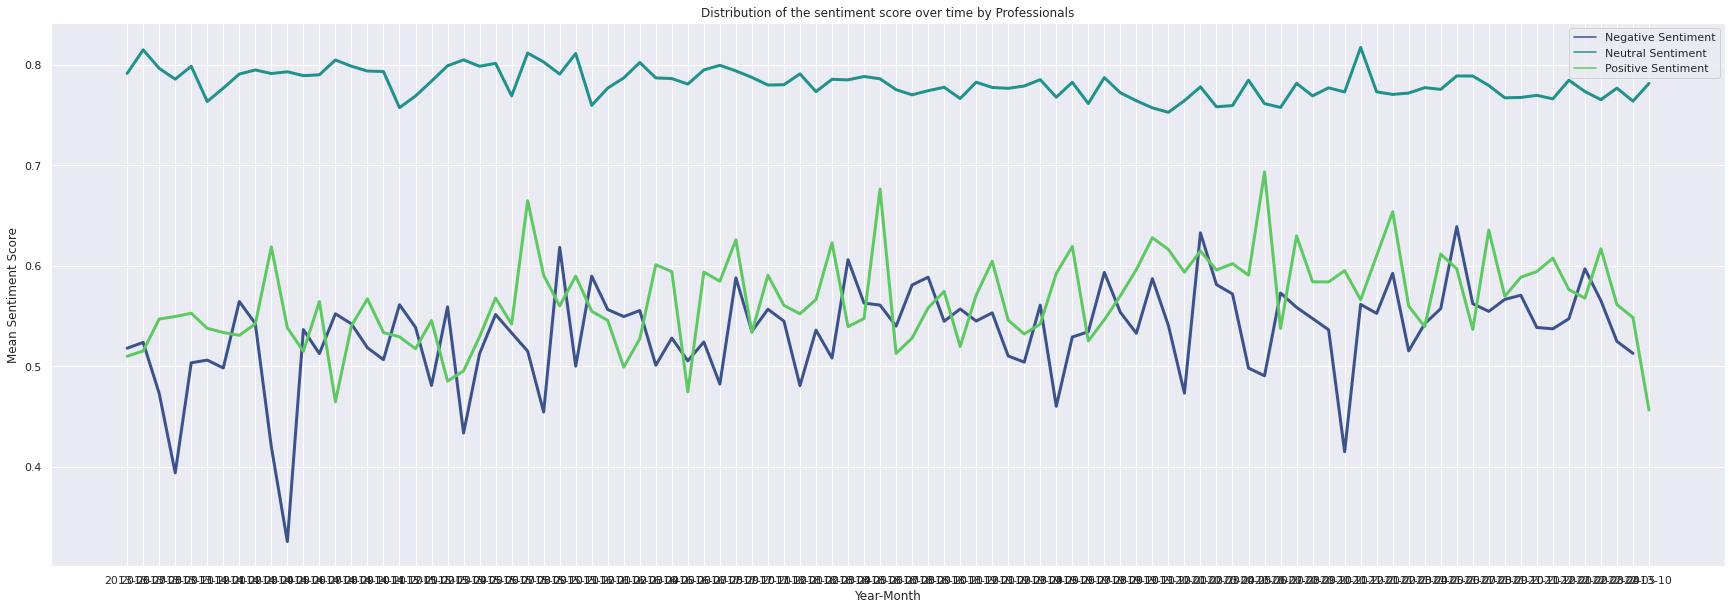

,Max_SentimentCol,YM,Year,Month,Max_SentimentValue
0,Negative Sentiment,2013-06,2013,06,0.518001
1,Negative Sentiment,2013-07,2013,07,0.523751
2,Negative Sentiment,2013-08,2013,08,0.473001
3,Negative Sentiment,2013-09,2013,09,0.394001
4,Negative Sentiment,2013-11,2013,11,0.503501
...,...,...,...,...,...
282,Positive Sentiment,2022-01,2022,01,0.576269
283,Positive Sentiment,2022-02,2022,02,0.567759
284,Positive Sentiment,2022-03,2022,03,0.616847
285,Positive Sentiment,2022-04,2022,04,0.561322


In [19]:
plot_sent_distribution(df_new,'Professionals')